In [1]:
using JuMP, Plots, FastGaussQuadrature, Jacobi, Ipopt#, NLopt

# 最速降下問題の最適制御（擬スペクトル法）
縁あって授業で数値計算で最適制御を行う課題をする機会があったので
$$
\dot{x} = \sqrt{2gy} \cos{\gamma}  \qquad x(0) = 0
$$
$$
\dot{y} = \sqrt{2gy} \sin{\gamma}  \qquad y(0) = 0
$$
$$
\dot{X} = F(X,U,t)
$$
で与えられるときに最短時間で
$$
x(t_f) = l \qquad  (l > 0)
$$
に到達するための制御変数 $\gamma$（flight-path angle）をGauss Pseudospectral Methodを用いて求めてみたいと思う．

本ページにおいては，$g$を重力加速度とする．
計算にあたって使用した手法はGauss Pseudospectral Method(GPM)，プログラミング言語はJulia lang(v1.1)．モデリングライブラリはJuliaOpt（JuMP），最適化ソルバーについては `Ipopt` を使用した．最適化ライブラリのモデル記述の癖が強すぎたため最終的なコードはダイナミクスをベタ書きしているが，関数ラッパーを後々作成するために逐次関数化したものを残している．

In [2]:
const MOI = JuMP.MathOptInterface
const g = 9.8    # [m/s^2]
const X₀ = [0., 0.]    # Initial position
"""dynamics"""
∂x(y, u) = sqrt(2g*y)*cos(u)
∂y(y, u) = sqrt(2g*y)*sin(u)
∂X(X,U,τ) = [∂x(X[2], U[1]), ∂y(X[2], U[1])]

∂X (generic function with 1 method)

$[-1,1]$で正規化した時刻$t_0,...,t_N$において，

$N$次のLegendre多項式 $L_N$を用いて関数
$$
\phi_{l}(t) :=\frac{1}{N(N+1) L_{N}\left(t_{l}\right)} \cdot \frac{\left(t^{2}-1\right) \dot{L}_{N}(t)}{t-t_{l}}
$$
$$
=\prod_{j=0, j \neq i}^{N} \frac{\tau-\tau_{j}}{\tau_{i}-\tau_{j}}
$$
を定義すると，
$$
\phi_{l}\left(t_{j}\right)=\left\{\begin{array}{ll}{1} & {\text { if } l=j} \\ {0} & {\text { if } l \neq j}\end{array}\right.
$$
となることがわかる．

ただし，$t_i$は$N$次のGauss-Legendre Quadratureの$i$番目のノード($N$次Legendre多項式の$i$番目の零点)である．

In [3]:
τ(t, T) = T*(t+1)/2
# ϕ(t, l, N) = (t^2-1)*dlegendre(t,N)/(N*(N+1)*legendre(gausslegendre(N)[1][l], N)*(t-gausslegendre(N)[1][l]))
ϕ(l, j) = l==j ? 1 : 0

ϕ (generic function with 1 method)

$$
t = \frac{t_f-t_0}{2}\tau + \frac{t_f+t_0}{2}
$$
によって正規化された時刻は元の時間スケールに戻るので，

In [4]:
realtime(τ,tf,t0)=(tf-t0)/2*τ+(tf+t0)/2

realtime (generic function with 1 method)

サンプリング点は $[-1,1]$ で以下のように分布する．

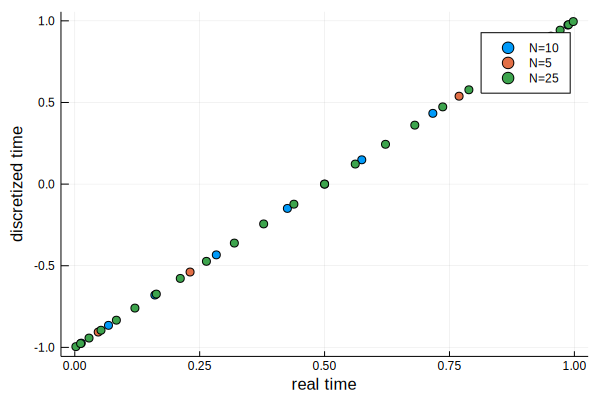

In [5]:
t10 = gausslegendre(10)[1]
t5  = gausslegendre(5 )[1]
t25 = gausslegendre(25)[1]
scatter(realtime.(t10,1,0),t10, label="N=10", ylabel="discretized time", xlabel="real time")
scatter!(realtime.(t5,1,0),t5, label="N=5" )
scatter!(realtime.(t25,1,0),t25,label="N=25")

したがって，元のダイナミクスについて，
$$
F^{N}(t) :=\sum_{l=0}^{N} F\left(t_{l}\right) \phi_{l}(t)
$$
$t$は離散化されているので，
$$
F^{N}\left(t_{k}\right)=F\left(t_{k}\right), \qquad k=0,1, \cdots, N
$$
とわかる．$x, y, u$についても同様に$\phi$を用いて離散化できる．

$\dot{F}$については，
$$
\dot{F}^{N}\left(t_{m}\right)=\sum_{l=0}^{N} D_{m l} F\left(t_{l}\right)
$$
で表される．ただし，
$$
D_{k i}=\dot{L}_{i}\left(\tau_{k}\right)=\sum_{l=0}^{N} \frac{\prod_{j=0, j \neq i, l}^{N}\left(\tau_{k}-\tau_{j}\right)}{\prod_{j=0, j \neq i}^{N}\left(\tau_{i}-\tau_{j}\right)}
$$
$$
k = 1, ..., N \quad and \quad i = 0, ..., N
$$
なる$(N,N+1)$行列である．

In [6]:
struct GPMsetting
    N::Int
    D::Matrix
    τ::Vector
    w::Vector
end
function GPMsetting(N)
    D = zeros(N,N+1)
    τ, w = gausslegendre(N)
    τ = append!(-1*ones(1), τ)
    τ = append!(τ, ones(1))
    for k in 2:N+1
        for l in 1:N+1
            if k==l
                D[k-1,l] = 0
                for m in 1:N+1
                    if m != k
                        D[k-1,l] += 1.0/(τ[k]-τ[m])
                    end
                end
            else
                D[k-1,l] = 1.0/(τ[l]-τ[k])
                for m in 1:N+1
                    if m != k && m != l
                        D[k-1,l] *= (τ[k]-τ[m])/(τ[l]-τ[m])
                    end
                end
            end
        end
    end
    return GPMsetting(N, D, τ, w)
end

GPMsetting

離散化されたダイナミクスは，
$$
\sum_{i=0}^{N} D_{k i} \mathbf{X}_{i}-\frac{T}{2} \mathbf{f}\left(\mathbf{X}_{k}, \mathbf{U}_{k}, \tau_{k} ; T\right)=\mathbf{0} \qquad(k=1, \ldots, N)
$$
$$
\mathbf{X}_{f} \equiv \mathbf{X}_{0}+\frac{T}{2} \sum_{k=1}^{N} w_{k} \mathbf{f}\left(\mathbf{X}_{k}, \mathbf{U}_{k}, \tau_{k} ; T\right)
$$
目的関数はGauss-Lobattoの積分公式より，
$$
\int_{-1}^{1} g\left(x^{N}(t), y^{N}(t), u^{N}(t), t, T\right) d t=\sum_{k=0}^{N} g\left(x^{N}\left(t_{k}\right), y^{N}(t_k), u^{N}\left(t_{k}\right), t_{k}, T\right) w_{k}
$$
なる重み付き線形和で表される．ただし，
$$
w_{k}=\frac{2}{N(N+1)} \cdot \frac{1}{\left[L_{N}\left(t_{k}\right)\right]^{2}} \qquad k=0,1, \cdots, N
$$
なる，Gauss-Legendre quadratureの重みである．したがって，
$$
J=\Phi\left(\mathbf{X}_{0}, 0, \mathbf{X}_{f}, T\right)+\frac{T}{2} \sum_{k=1}^{N} w_{k} g\left(\mathbf{X}_{k}, \mathbf{U}_{k}, \tau_{k} ; T\right)
$$
制約条件は
$$
\mathbf{C}\left(\mathbf{X}_{k}, \mathbf{U}_{k}, \tau_{k} ; t_{0}, t_{f}\right) \leq \mathbf{0} \qquad(k=1, \ldots, N)
$$
となる．

初期値と最終値の拘束条件は，
$$
\phi\left(\mathbf{X}_{0}, t_{0}, \mathbf{X}_{f}, t_{f}\right)=\mathbf{0}
$$

In [7]:
# Gauss-Legendre の擬スペクトル法モデルの関数ラッパー．今回は使用していない．
DiscDynamics(X::Vector,U::Vector,t0, tf,f, set::GPMsetting) = sum(set.D*X,axis=1)-(tf-t0)/2*f(X,U,set.τ)
Xf(X::Vector,U::Vector,X₀, t0, tf, f, set::GPMsetting) = X₀ + (tf-t0)/2*sum(set.w*f(X,U,set.τ))
CostFun(X₀, t0, Xf, tf, Φ, g, set::GPMsetting) = Φ(X₀, t0, Xf, tf) + (tf-t0)/2*sum(set.w*g(X,U,set.τ))

CostFun (generic function with 1 method)

本問題におけるダイナミクスと制約条件と目的関数は下記のコードの通りとなる．移動距離 $l=1000$[m]，分割数 $N=50$として最適制御を行なった結果は以降の図に示す

In [8]:
# Pseudospectral Method
# N=200
N=50
l=1000.

gpmset = GPMsetting(N)
m = Model(with_optimizer(Ipopt.Optimizer, print_level=0))

@variable(m, x[1:N+1], start=0.5)
@variable(m, y[1:N+1], start=0.5)
@variable(m, -π+1e-6 <= u[1:N+1] <= π-1e-6 )
@variable(m, -1e-6 <= t0 <= 1e-6 )
@variable(m, 0 <= tf)

@NLobjective(m, Min, (tf-t0))

@NLconstraint(m, xDynCon[k=2:N+1], sum(gpmset.D[k-1, i]*x[i] for i in 1:N+1)-(tf-t0)/2 *sqrt(2*g*y[k])*cos(u[k])  ==0)    # x-dynamics constraint
@NLconstraint(m, yDynCon[k=2:N+1], sum(gpmset.D[k-1, i]*y[i] for i in 1:N+1)-(tf-t0)/2 *sqrt(2*g*y[k])*sin(u[k])  ==0)    # y-dynamics constraint

@NLconstraint(m, X₀[1] + (tf-t0)/2*sum(gpmset.w[i-1]*sqrt(2g*y[i])*cos(u[i]) for i in 2:N+1)==l)    # Final state condition
# @NLconstraint(m, X₀[2] + (tf-t0)/2*sum(gpmset.w[i-1]*sqrt(2g*y[i])*sin(u[i]) for i in 2:N+1)==l)    # Final state condition
@constraint(m, t0==0)    # Initial time condition
@constraint(m, x[1]==X₀[1])
@constraint(m, y[1]==X₀[2])

# print(m)

status = optimize!(m)

println("Objective value: ", JuMP.objective_value(m))
# println("x = ", JuMP.value.(x))
# println("y = ", JuMP.value.(y))
# println("u = ", JuMP.value.(u))
# println("tf= ", JuMP.value(tf))
# println("t0= ", JuMP.value(t0))


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Objective value: 17.888822007408187


制御料については以下のような時間履歴となる

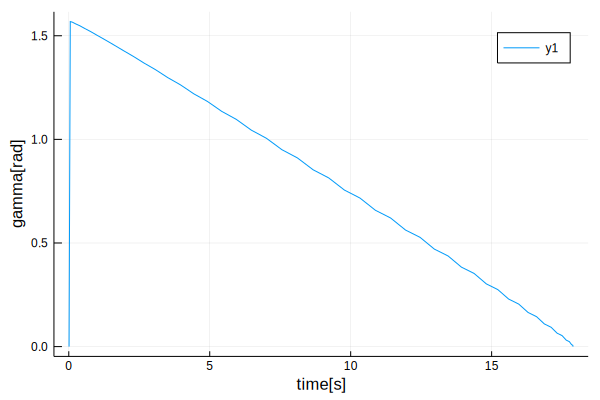

In [9]:
plot(realtime.(gpmset.τ[2:end],JuMP.value(tf),JuMP.value(t0)),JuMP.value.(u), ylabel="gamma[rad]", xlabel="time[s]")

これはまず垂直に機体を降下させたとに機首を引き上げるため，位置エネルギーを運動エネルギーとして効率よく使っているためであると考えられる．

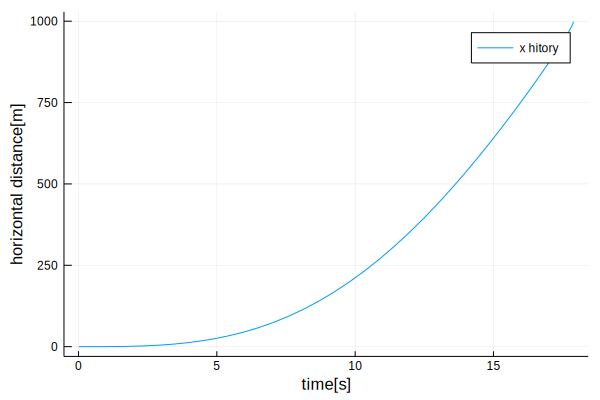

In [10]:
plot(realtime.(gpmset.τ[2:end],JuMP.value(tf),JuMP.value(t0)),JuMP.value.(x), ylabel="horizontal distance[m]", xlabel="time[s]", label="x hitory")

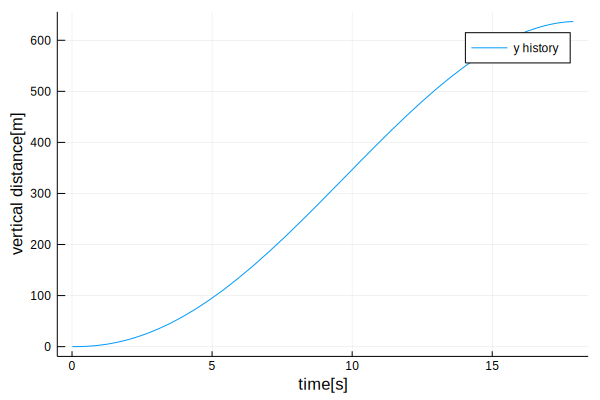

In [11]:
plot(realtime.(gpmset.τ[2:end],JuMP.value(tf),JuMP.value(t0)),JuMP.value.(y), ylabel="vertical distance[m]", xlabel="time[s]",label="y history")

## 制約条件の付加
今，この問題に対してさらに状態量制約条件
$$
y \leq x\tan{\theta}+h
$$
が付与されたときを考える．出来るだけ機体を制約条件ギリギリに沿わせながら制御していくと予想される．

In [12]:
# Pseudospectral Method
# N=200
# N=100
N=50
l=1000.
θval=π/8
hval=300.

gpmset = GPMsetting(N)
mod = Model(with_optimizer(Ipopt.Optimizer, print_level=0))

@variable(mod, x[1:N+1], start=0.5)
@variable(mod, y[1:N+1], start=0.5)
@variable(mod, -π+1e-6 <= u[1:N+1] <= π-1e-6 )
@variable(mod, -1e-6 <= t0 <= 1e-6 )
@variable(mod, 0 <= tf)
@variable(mod, h==hval)
@variable(mod, θ==θval)

@NLobjective(mod, Min, (tf-t0))

@NLconstraint(mod, xDynCon[k=2:N+1], sum(gpmset.D[k-1, i]*x[i] for i in 1:N+1)-(tf-t0)/2 *sqrt(2*g*y[k])*cos(u[k])  ==0)    # x-dynamics constraint
@NLconstraint(mod, yDynCon[k=2:N+1], sum(gpmset.D[k-1, i]*y[i] for i in 1:N+1)-(tf-t0)/2 *sqrt(2*g*y[k])*sin(u[k])  ==0)    # y-dynamics constraint
@NLconstraint(mod, hCon[k=2:N+1], y[k]-x[k]*tan(θ)<=h)

@NLconstraint(mod, (X₀[1] + (tf-t0)/2*sum(gpmset.w[i]*sqrt(2*g*y[i+1])*cos(u[i+1]) for i in 1:N))==l)    # Final state condition
@constraint(mod, t0==0)    # Initial time condition
@constraint(mod, x[1]==X₀[1])
@constraint(mod, y[1]==X₀[2])

# print(mod)

status = optimize!(mod)

println("Objective value: ", JuMP.objective_value(mod))
# println("x = ", JuMP.value.(x))
# println("y = ", JuMP.value.(y))
# println("u = ", JuMP.value.(u))
# println("tf= ", JuMP.value(tf))
# println("t0= ", JuMP.value(t0))

Objective value: 3.9223578100823357


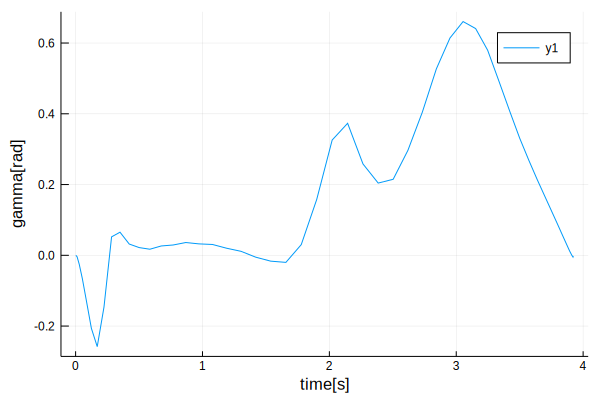

In [13]:
plot(realtime.(gpmset.τ[2:end],JuMP.value(tf),JuMP.value(t0)),JuMP.value.(u), ylabel="gamma[rad]", xlabel="time[s]")

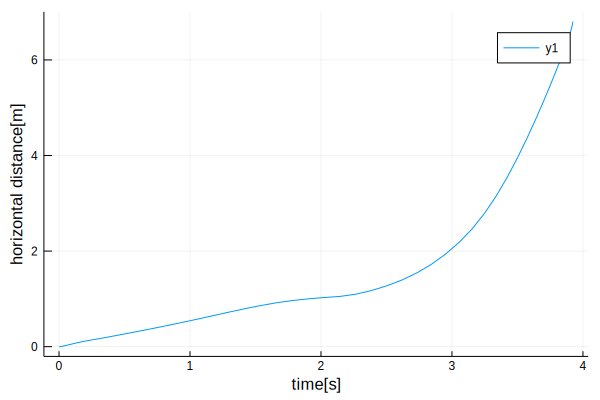

In [14]:
plot(realtime.(gpmset.τ[2:end],JuMP.value(tf),JuMP.value(t0)),JuMP.value.(x), ylabel="horizontal distance[m]", xlabel="time[s]")

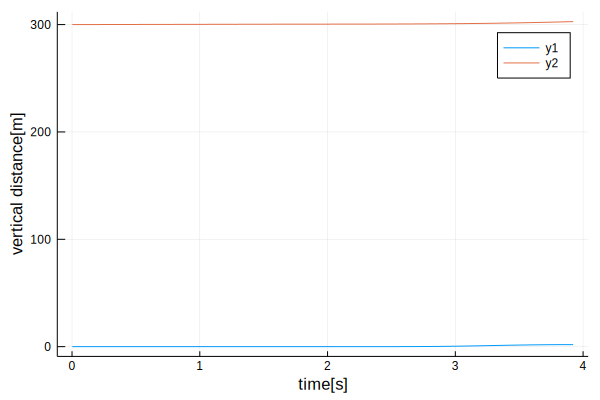

In [15]:
plot(realtime.(gpmset.τ[2:end],JuMP.value(tf),JuMP.value(t0)),JuMP.value.(y), ylabel="vertical distance[m]", xlabel="time[s]")
plot!(realtime.(gpmset.τ[2:end],JuMP.value(tf),JuMP.value(t0)),JuMP.value.(x).*tan(JuMP.value(θ)).+JuMP.value(h))

このように，制御が十分終点まで収束していないことがわかる．制約条件が離散点分だけ新たな拘束条件によって増えたことが原因？

### 参考文献
Elnagar, Gamal, Mohammad A. Kazemi, and Mohsen Razzaghi. "The pseudospectral Legendre method for discretizing optimal control problems." IEEE transactions on Automatic Control 40.10 (1995): 1793-1796.

Benson, David A., et al. "Direct trajectory optimization and costate estimation via an orthogonal collocation method." Journal of Guidance, Control, and Dynamics 29.6 (2006): 1435-1440.